In [14]:
import numpy as np
import pandas as pd
from pygimli.meshtools import readGmsh
import pygimli as pg
import glob
import pygimli.meshtools as mt

from scipy.spatial import distance_matrix
from scipy.interpolate import griddata
from itertools import combinations
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt

from scipy.spatial import Delaunay, cKDTree
from pygimli.physics import ert
from ertoolbox import inversion
from ertoolbox import ert_postprocessing

folder = 'p:/11209233-mad09a2023ijsselmeer3d/C_Work/02_FM/03_postprocessing/09_input_tomografische_metingen/voorhaven_kwz/sal_tem'
counter = 0
for csv in glob.glob(f"{folder}/*.csv"):
    counter+=1
    if counter == 25:
        data = pd.read_csv(csv)
# csv = '../data/testgrid.csv'
# data = pd.read_csv(csv)
print(data, csv)
data.columns =['x', 'z', 'salinity', 'temperature'] #for now these columns are nesseccary!!
# data.columns =['x', 'y', 'z', 'resistivity'] 
data["resistivity"] = 1 / ert_postprocessing.salinity_to_conductivity(
        data["salinity"], data["temperature"]
    )

     Distance [m]   Z [m NAP]   Salinity [psu]   Temperature [degC]
0           12.99      -1.564             0.55                18.93
1           12.99      -1.503             0.55                18.93
2           12.99      -1.380             0.55                18.93
3           12.99      -1.257             0.54                18.94
4           12.99      -1.134             0.54                18.95
..            ...         ...              ...                  ...
563         98.94      -0.663             0.54                18.90
564         98.94      -0.534             0.54                18.88
565         98.94      -0.406             0.54                18.85
566         98.94      -0.277             0.54                18.77
567         98.94      -0.213             0.54                18.77

[568 rows x 4 columns] p:/11209233-mad09a2023ijsselmeer3d/C_Work/02_FM/03_postprocessing/09_input_tomografische_metingen/voorhaven_kwz/sal_tem\crosssection_sal_tem_20220803_0000.csv


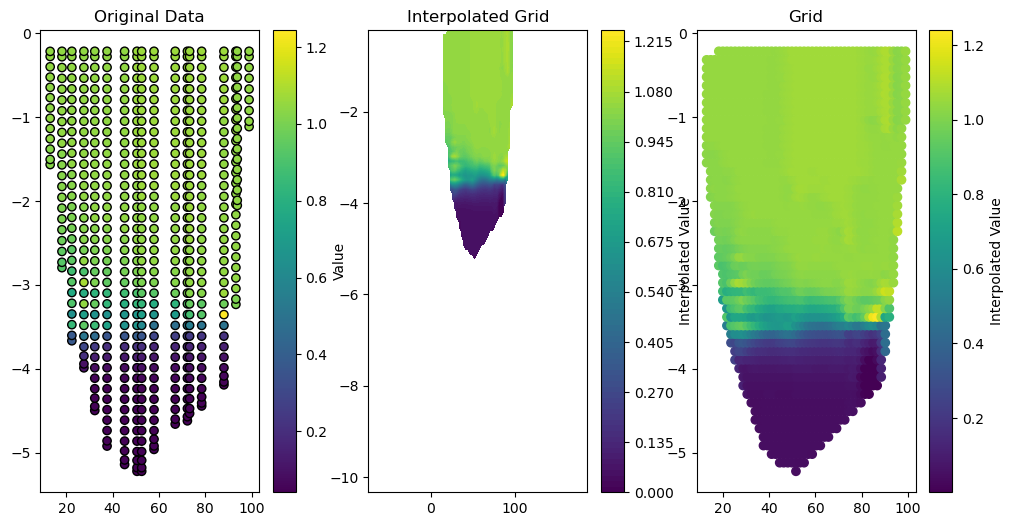

In [92]:
# Define grid parameters
x_min, x_max = data['x'].min(), data['x'].max()
z_min, z_max = data['z'].min(), data['z'].max()
grid_size = 50  # Number of grid points along each axis

# Create a regular grid
x_grid = np.linspace(x_min, x_max, grid_size)
z_grid = np.linspace(z_min, z_max, grid_size)
X_grid, Z_grid = np.meshgrid(x_grid, z_grid)
Y_grid = np.zeros(np.shape(X_grid))

# Stack grid data
xyz = np.column_stack([X_grid.flatten(),Z_grid.flatten()])

# Prepare data for interpolation
points = data[['x', 'z']].values 
values = data['resistivity'].values

# Interpolate
grid_values = griddata(points, values, (X_grid, Z_grid), method='cubic')
grid_values[grid_values<0] = 0.001

# Interpolate onto the structured grid
grid_z = griddata(points, values, (X_grid, Z_grid), method='cubic')

##---
padding_points = 50  # Number of points for padding
new_grid_size = grid_size + padding_points

# Extend x and z grid with 50 points padding on both sides (left, right, below)
x_grid_padded = np.linspace(x_min - (x_grid[1] - x_grid[0]) * padding_points, 
                            x_max + (x_grid[1] - x_grid[0]) * padding_points, 
                            new_grid_size)
z_grid_padded = np.linspace(z_min - (z_grid[1] - z_grid[0]) * padding_points, 
                            z_max, 
                            new_grid_size)
X_grid_padded, Z_grid_padded = np.meshgrid(x_grid_padded, z_grid_padded)
Y_grid_padded = np.zeros(np.shape(X_grid_padded))
grid_values_padded = griddata(points, values, (X_grid_padded, Z_grid_padded), method='cubic')
# Interpolate onto the extended grid
grid_values_padded = griddata(points, values, (X_grid_padded, Z_grid_padded), method='cubic')
grid_values_padded[grid_values_padded < 0] = 0.00001

# grid_values_padded = np.nan_to_num(grid_values_padded, nan=1000)

xyz_padded = np.column_stack([X_grid_padded.flatten(),Z_grid_padded.flatten()])
##---

# Plot original points
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.scatter(data['x'], data['z'], c=data['resistivity'], cmap='viridis', edgecolor='k')
plt.title('Original Data')
plt.colorbar(label='Value')

# Plot interpolated grid
plt.subplot(1, 3, 2)
plt.contourf(X_grid_padded, Z_grid_padded, grid_values_padded, levels=100, cmap='viridis')
plt.title('Interpolated Grid')
plt.colorbar(label='Interpolated Value')
# X_grid = data['x']
# Z_grid = data['z']
# grid_values = data['salinity']
plt.subplot(1, 3, 3)
plt.scatter(X_grid, Z_grid, c=grid_values)
plt.title('Grid')
plt.colorbar(label='Interpolated Value')
plt.show()


In [93]:
# Create a DataFrame
df = pd.DataFrame(
    {"x": data['x'], "z": data['z'], "value": data['resistivity']}
) 
from scipy import interpolate

# Only use valid data points
df = df.dropna()
# #take 1 node above the bottom
min_z_indices = df.groupby('x')['z'].idxmin()
df = df.drop(min_z_indices)
df.reset_index(drop=True, inplace=True)

min_z_indices = df.groupby("x")["z"].idxmin()
min_z_df = df.loc[min_z_indices]
min_z_df.reset_index(drop=True, inplace=True)

x_points = min_z_df['x']
z_points = min_z_df['z']
# Interpolation
distance = 1  # cm

# Calculate the distances between the original points
distances = np.sqrt(np.diff(x_points)**2 + np.diff(z_points)**2)

# Calculate cumulative distances
cumulative_distances = np.concatenate(([0], np.cumsum(distances)))

# New distance points from the start to the end
new_distances = np.arange(0, cumulative_distances[-1], distance)

# Interpolating
new_x = np.interp(new_distances, cumulative_distances, x_points)
new_z = np.interp(new_distances, cumulative_distances, z_points)

# Resulting interpolated points
interpolated_points = np.column_stack((new_x, new_z))


def calculate_distances(points):
    """
    Calculate distances between consecutive points.

    Parameters:
    points (array-like): A 2D array or list of points where each point is represented as [x, y].

    Returns:
    np.ndarray: An array of distances between consecutive points.
    """
    points = np.array(points)  # Ensure the input is a NumPy array
    # Calculate the distances between consecutive points
    distances = np.sqrt(np.sum(np.diff(points, axis=0)**2, axis=1))
    return distances


distances = calculate_distances(interpolated_points)

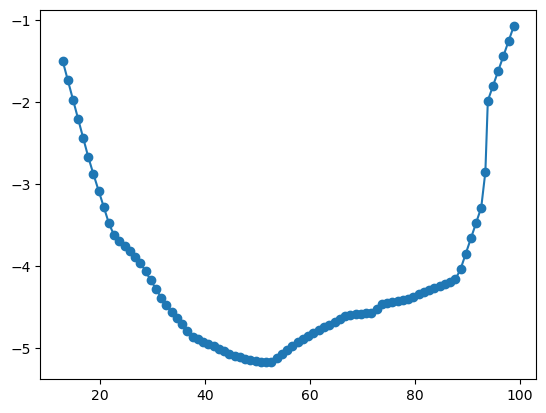

In [94]:
plt.plot(new_x,new_z,'o-')

In [1]:

rvector3_list = [pg.RVector3(x, z, 0) for x, z in zip(new_x,new_z)]
plc = mt.createMesh(rvector3_list, quality=134.2)
for p in xyz:
    plc.createNode((p[0],p[1]))
mesh = mt.createMesh(plc)
ax, _ = pg.show(mesh, markers=False, showMesh=True)
print(mesh)
# plc = mt.createmesh(rvector3_list, paraDepth=20, boundary=1)
# plc.createEdge(plc.node(0),plc.node(2*len(rvector3_list)), marker=1)
# plc.addRegionMarker([50, -0.1], marker=3)
# ax, _ = pg.show(plc, markers=True)

# for i, n in enumerate(plc.nodes()[:]):
#     ax.text(n.x(), n.y(), str(i))

NameError: name 'new_x' is not defined

Mesh: Nodes: 88 Cells: 147 Boundaries: 234


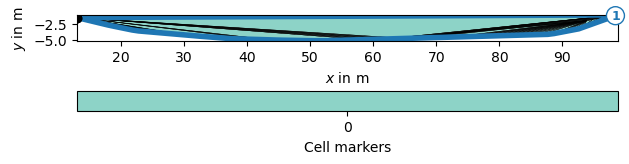

In [87]:
# mesh_nodes = plc.nodes
# kdtree = cKDTree(xyz)

# # Now map each triangle to the values from the structured grid based on the closest node
# triangle_values = []

# # Access the mesh cells (triangles)
# for cell in plc.cells():
#     # Each cell is a triangle, and the nodes of the triangle are in cell.nodes()
#     triangle_nodes = cell.nodes()
    
#     # Find the closest structured grid point for each node
#     values_for_triangle = []
#     for node in triangle_nodes:
#         point = np.array([node.x(), node.z()])
        
#         # Find the nearest point in the structured grid
#         _, idx = kdtree.query(point)
#         # Get the value corresponding to this point
#         value = grid_values.flatten()[idx]
#         values_for_triangle.append(value)
    
#     # Calculate the average value for the triangle, or use another method
#     triangle_values.append(np.mean(values_for_triangle))

# # Now each triangle in the mesh has a corresponding value (triangle_values)
# print("Triangle values:", triangle_values)


mesh = mt.createMesh(rvector3_list, quality=34.2)
# for b in mesh.boundaries():
#     if b.marker() == 1 and not b.outside():
#         b.setMarker(-2)
ax, _ = pg.show(mesh, markers=True, showMesh=True)
print(mesh)

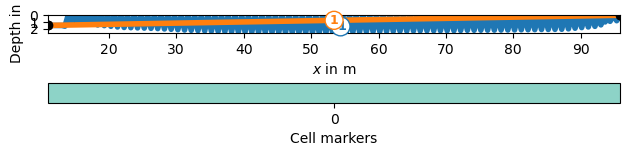

In [82]:
water = mesh.createSubMesh(mesh.cells(mesh.cellMarkers() == 0))

ax, cb = pg.show(water,markers=True, showMesh=True)